In [110]:
from IsingRG import *
import jax
import jax.numpy as jnp
import matplotlib.pylab as plt
import optax
from tqdm import tqdm
import seaborn as sns

In [111]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

Definition of the random geneartor keys

In [112]:
rng_ = jax.random.PRNGKey(1)
rng_, rng_configuration, rng_sampling, rng_blocking, rng_batch = jax.random.split(rng_, 5)

# Simulation of the ising model 

We extract and plot a random initial configuration

/var/folders/ms/drsg6x915v9gddm7s_c25j2m0000gn/T/ipykernel_52870/2019206276.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


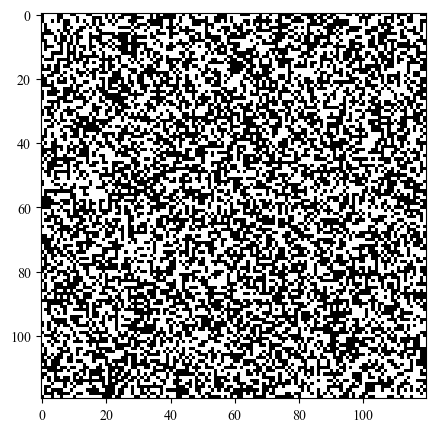

In [140]:
L = 120
initial_configuration = jax.random.randint(rng_configuration, (L, L), minval=0, maxval=2) * 2 - 1
plt.rcParams["figure.figsize"] = (6,5)
fig, ax = plt.subplots(1,1)
ax.imshow(initial_configuration, cmap = 'gray')
fig.show()

### Sampling of the configuraitons

Using the function Sample() We can sample configurations from the Ising probability distribution
$$ \mathcal P = \frac 1 Z \exp \left( - \sum_{d}\sum_{|n-m| = d} \mathcal K_d \ \sigma_{n_x, n_y} \sigma_{m_x, m_y}  \right ) $$
with nearest neighbours interaction $\mathcal K_1 = 0.2$ and next nearest neighbours interaction $\mathcal K_2 = 0.08$.

We use a standard Metropolis Monte Carlo sampling algorithm

In [160]:
#K_simulation = jnp.array([0.203, 0.078])
K_simulation = jnp.array([0.18, 0.08]) #paramagnetica values of the parameters
num_samples = 300 
num_filps = 10*L*L
Samples = Sample(initial_configuration, rng_sampling, num_filps, num_samples, K_simulation);

Let's show some of the generated configurations

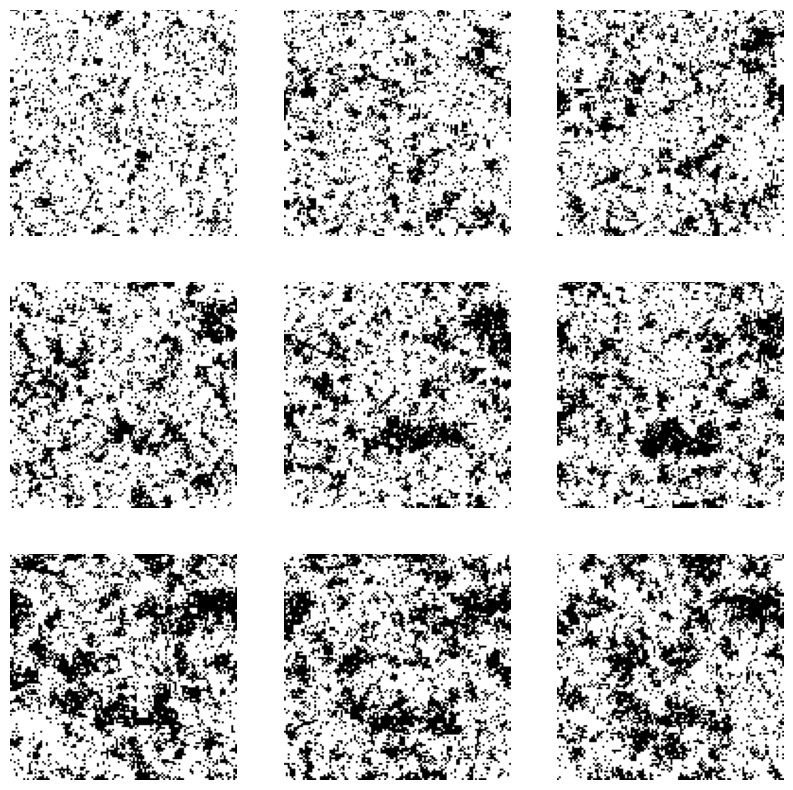

In [161]:
n = 3
m = 3
fig, ax = plt.subplots(n,m, figsize=(10,10))
for i in range (ax.size):
    x,y = divmod(i,m)
    ax[x,y].imshow(Samples[i,:,:], cmap='gray')
    ax[x,y].axis(False)
    

## Blocking 

Let's see the effect of the blocking procedure on some configurations of the ising model:

In [143]:
rng_simulation1, rng_simulation2, rng_simulation3 = jax.random.split(rng_sampling, 3)
initial_configuration = jnp.ones((L,L))
K_paramagnetic = jnp.array([0.2])
K_ferromagnetic = jnp.array([0.48])
K_near_critical = jnp.array([0.4])

num_samples = 600
Samples_para = Sample(initial_configuration, rng_simulation1, L * L, num_samples, K_paramagnetic)
Samples_ferro = Sample(initial_configuration, rng_simulation2, L * L, num_samples, K_ferromagnetic)
Samples_near_critical = Sample(initial_configuration, rng_simulation3, L * L, num_samples, K_near_critical)

Let's check that effectively as claimed the configurations are respectively in the paramagnetic, ferromagnetic and critical regime

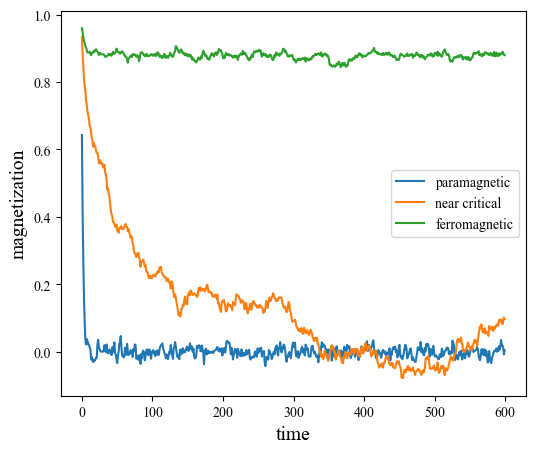

In [144]:
plt.plot(jnp.average(Samples_para, axis=[1,2]), label = "paramagnetic")
plt.plot(jnp.average(Samples_near_critical, axis=[1,2]), label = "near critical")
plt.plot(jnp.average(Samples_ferro, axis=[1,2]), label = "ferromagnetic")
plt.xlabel("time", fontsize=14)
plt.ylabel("magnetization", fontsize = 14)
plt.legend(fontsize=10)
plt.show()

Clearly the blue and green curves correspond respectively to the paramagnetic and ferromagnetic phases. We can tell that the orange curve corresponds to a near critical system because of its slow dynamics

### Blocking 

Here we show the effect of the blocking  transformation on some configurations of the Ising model: 

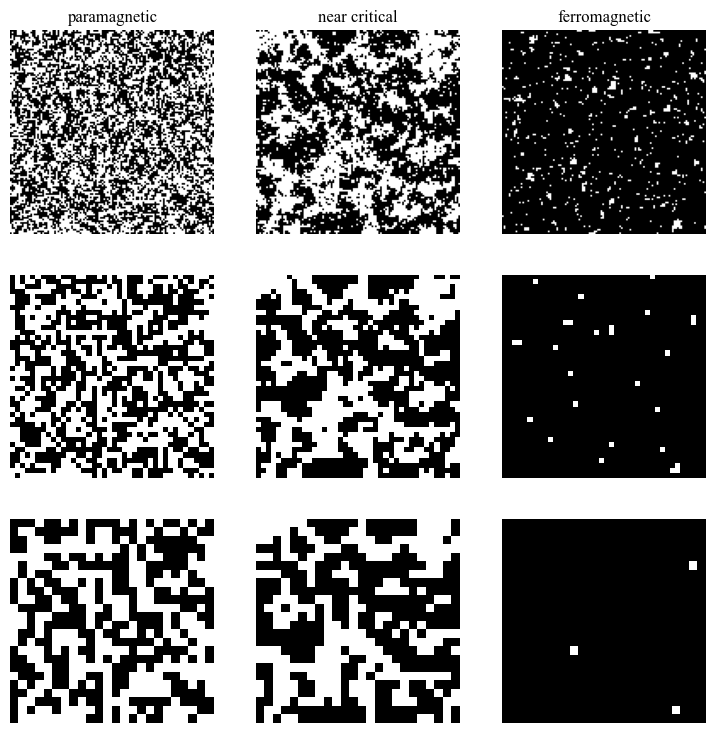

In [145]:
fig, ax = plt.subplots(3,3, figsize = (9,9));
ax[0,0].set_title("paramagnetic")
ax[0,1].set_title("near critical")
ax[0,2].set_title("ferromagnetic")

for i,x in enumerate([Samples_para, Samples_near_critical, Samples_ferro]): 
    for j,bs in enumerate([1,3,5]):
        x_blocked =  Block_configuration(x[-1,:,:][jnp.newaxis,:,:], bs, rng_blocking)
        """The function Block configurations is made to work on a set of configurations of the type
        [num_samples,L,L], so if we want to apply this function to a single configuration we have to add a
        dummy axis with jnp.new-axis"""
        ax[j,i].imshow(-x_blocked[0,:,:], cmap='gray')
        ax[j,i].axis(False)

## Inference - Inverse Ising Problem 

### Loss landscape

The solution of the inverse Ising problem is obtained by minimizing the function,

$$ F = \sum_{n} f_n $$

Which is implemented in function Pseudo_Loss in the IsingRG_lib.py file, see equation 20 in the main text

Before proceeding with the solution of the optimization problem we plot the function F on the $\{ \mathcal K_1, \ \mathcal K_2 \}$ plane

In [162]:
Termalizatermalization_stepstion = 100
batch = jax.random.permutation(rng_batch, num_samples-termalization_steps)[0:100]+termalization_steps
k1_grid, k2_grid = jnp.meshgrid(jnp.linspace(-0.1,0.5,20), jnp.linspace(-0.1,0.5,20));
k_grid = jnp.stack([k1_grid, k2_grid]).transpose(1,2,0)
loss_k1_k2 = (lambda x,y : Pseudo_Loss([x,y],Samples[batch]))
landscape = jax.vmap(loss_k1_k2, in_axes=(0,0))(k1_grid.reshape(-1),k2_grid.reshape(-1)).reshape(k1_grid.shape);

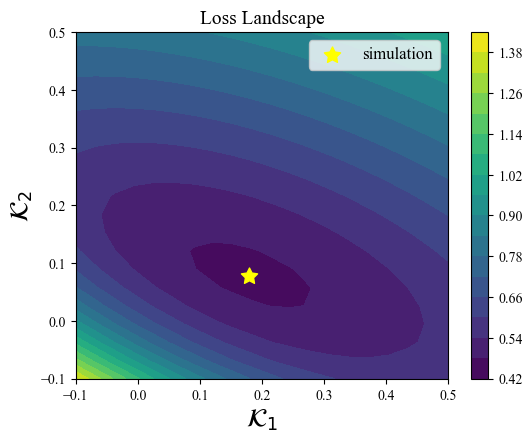

In [163]:
cmap =  sns.color_palette("viridis", as_cmap=True)
plt.rcParams["figure.figsize"] = (6,4.5)
plt.contourf(k1_grid, k2_grid, landscape, 15, cmap=cmap)
plt.colorbar()
plt.scatter([K_simulation[0]],[K_simulation[1]], c="yellow", marker=(5,1), s=150, label = "simulation")
plt.legend(fontsize = 12)
plt.xlabel("$\mathcal{K}_1$", fontsize = 18)
plt.ylabel("$\mathcal{K}_2$", fontsize = 18)
plt.title("Loss Landscape", fontsize = 14)
plt.show()

The yellow star corresponds to the parameters used to perform the simulation. We can see that the minimum of the loss function $F$ is very close to the parameters used to perform the simulation

### Inference

Let's see how the inference scheme proposed in the main text is able to find the minimum of the loss and infer the parameters of the model:

In [164]:
K_init = jnp.array([0.1,0.4])
K = K_init.copy()
K_trajectory_GD =[]
Loss_trajectory_GD = []
eta = 0.05

The function Pseudo_Loss_fn_and_grad in the Ising_RG.py file returns the loss and its gradient with respect to the couplings K, according to equation 21 of the main text. We optimize this function using the 

In [165]:
for iterations in tqdm(range(300)):
    loss, grad = Pseudo_Loss_fn_and_grad(K, Samples[batch,:,:])
    K_trajectory_GD.append(K)
    Loss_trajectory_GD.append(loss)
    K = K - eta*grad

100%|██████████| 300/300 [00:24<00:00, 12.28it/s]


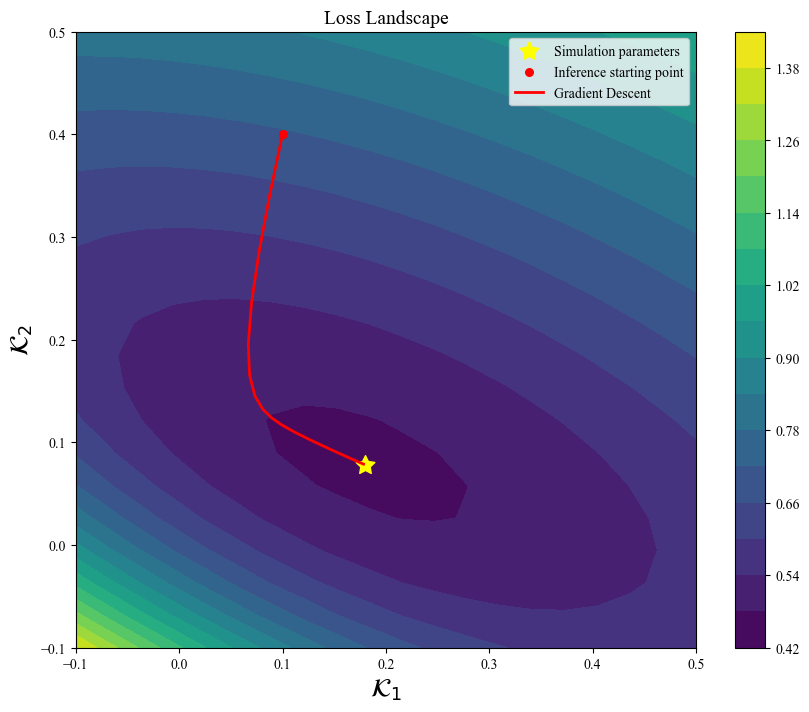

In [166]:
cmap =  sns.color_palette("viridis", as_cmap=True)
plt.rcParams["figure.figsize"] = (10,8)
Kt_GD = jnp.stack(K_trajectory_GD)
plt.contourf(k1_grid, k2_grid, landscape, 15, cmap=cmap)
plt.colorbar()
plt.scatter([K_simulation[0]],[K_simulation[1]], c="yellow", marker=(5,1), s=200, label = "Simulation parameters")
plt.scatter([K_init[0]],[K_init[1]], c="red", marker="o", s=30, label = "Inference starting point")
plt.legend(fontsize = 12)
plt.xlabel("$\mathcal{K}_1$", fontsize = 18)
plt.ylabel("$\mathcal{K}_2$", fontsize = 18)
plt.title("Loss Landscape", fontsize = 14)
plt.plot(Kt_GD[:,0], Kt_GD[:,1], c='red', lw = 2, label = "Gradient Descent")
plt.legend(fontsize = 10)
# plt.savefig("optimization_trajectory.pdf")
plt.show()

### Adam Optimization (optional)

Instead of simply following the gradient we can try to use some more sophisticated optimization scheme. We use the Adam algorithm build in the optax package

In [157]:
K = jnp.array([0.1,0.4])
K_trajectory_ADAM = []
Loss_trajectory_ADAM = []
eta = 0.05

In [158]:
optimizer = optax.adam(eta)
params = {'K': K}
opt_state = optimizer.init(params)
for iterations in tqdm(range(300)):
    loss, grads = Pseudo_Loss_fn_and_grad(params['K'], Samples[batch,:,:])
    K_trajectory_ADAM.append(params['K'])
    Loss_trajectory_ADAM.append(loss)
    grads = {'K': grads}
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

100%|██████████| 300/300 [00:24<00:00, 12.13it/s]


If we compare the solution of the gradient descent algorithm (basically following the gradient) with the Adam algorithm we see how faster ADAM finds the solution

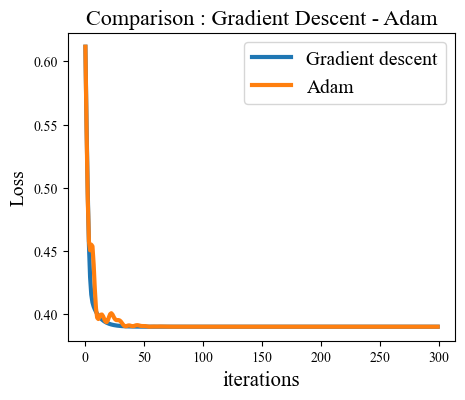

In [159]:
plt.rcParams["figure.figsize"] = (5,4)
plt.title("Comparison : Gradient Descent - Adam", fontsize=16)
plt.plot(Loss_trajectory_GD, lw = 3, label = "Gradient descent")
plt.plot(Loss_trajectory_ADAM, lw = 3, label = "Adam")
plt.xlabel("iterations", fontsize = 15)
plt.ylabel("Loss", fontsize = 14)
plt.legend(fontsize = 14)
plt.show()

We can clearly see how faster the Adam algorithm can find the solution.

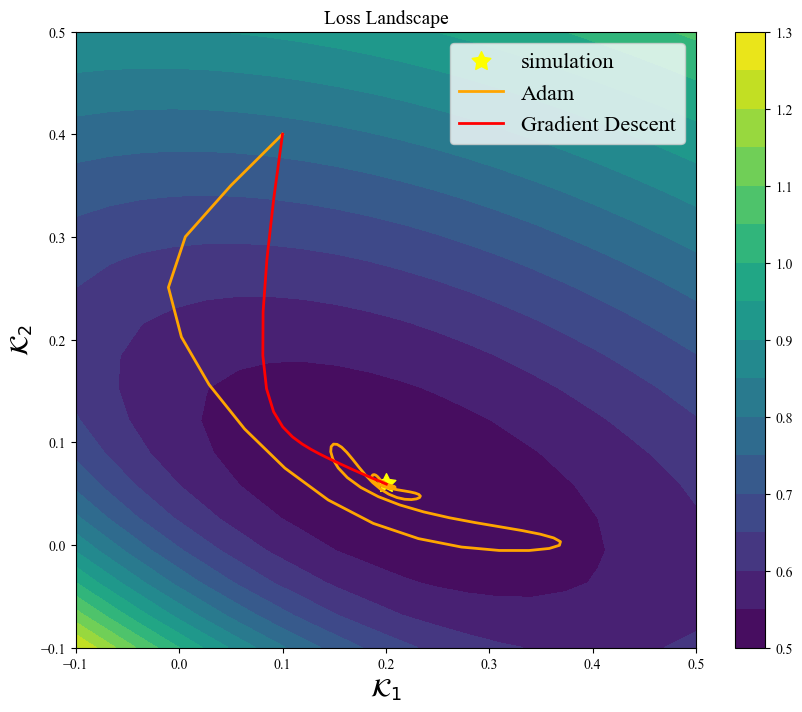

In [19]:
plt.rcParams["figure.figsize"] = (10,8)

Kt_ADAM = jnp.stack(K_trajectory_ADAM)
Kt_GD = jnp.stack(K_trajectory_GD)
plt.contourf(k1_grid, k2_grid, landscape, 15, cmap=cmap)
plt.colorbar()
plt.scatter([K_simulation[0]],[K_simulation[1]], c="yellow", marker=(5,1), s=200, label = "simulation")
plt.legend(fontsize = 12)
plt.xlabel("$\mathcal{K}_1$", fontsize = 18)
plt.ylabel("$\mathcal{K}_2$", fontsize = 18)
plt.title("Loss Landscape", fontsize = 14)
plt.plot(Kt_ADAM[:,0], Kt_ADAM[:,1], c='orange', lw = 2, label = "Adam")
plt.plot(Kt_GD[:,0], Kt_GD[:,1], c='red', lw = 2, label = "Gradient Descent")
plt.legend(fontsize = 16)
plt.show()

## Measuring the renormalization group flow

We are going to measure the renormalization group flow following the procedure described in figure 7 of the main text

#### single block size

First we are going to apply the procedure for a single block size.

The first step of the procedure described in figure 7 is to simulate the Ising model and get some equilibrium configurations:

In [46]:
K_simulation = jnp.array([0.203, 0.078])
L = 240
initial_configuration = jnp.ones((L,L))
#num_samples = 6000
num_samples = 3000
"""This might take a while"""
Samples = Sample(initial_configuration, rng_sampling, 30*L*L, num_samples, K_simulation);

We plot the magnetization of the system over time to have any idea of what the system is doing 

Text(0, 0.5, 'm')

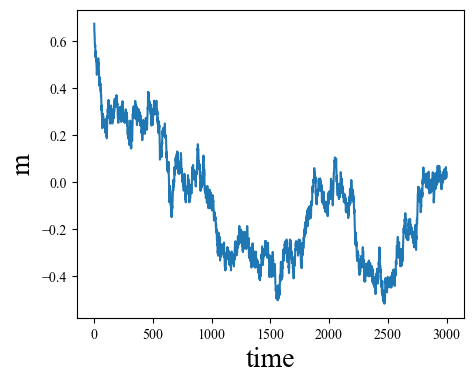

In [47]:
plt.rcParams["figure.figsize"] = (5,4)
plt.plot(jnp.average(Samples, axis =[1,2]))
plt.xlabel("time", fontsize =20)
plt.ylabel("m", fontsize =20)

We select some random configurations from Samples (neglecting the first half of the simulations, mainly because we want to use thermalized configurations and the first part of the dynamics is still influence by the initial condition)

Then we block the configurations using the BlockConfiguration function

In [49]:
termalization_steps = 100
batch_size = 1000
batch = jax.random.permutation(rng_,num_samples- termalization_steps )[0:batch_size]+termalization_steps
Block_size = 8
Blocked_Samples = Block_configuration(Samples[batch,:,:], Block_size,rng_blocking)

At this point we can apply the inverse Ising procedure to infer the couplings that would have generated the blocked configurations.

In [50]:
eta = 1
K_initial = jnp.array([0.4, 0.4, 0.4, 0.4])
K = K_initial.copy()
K_trajectory = []
Loss_trajectory = []
#eta = 0.05
eta = 0.025
for iterations in tqdm(range(500)):
    loss, grad = Pseudo_Loss_fn_and_grad(K, Blocked_Samples)
    K_trajectory.append(K)
    Loss_trajectory.append(loss)
    K = K - eta*grad
K_blocked_traj_GD_np = jnp.stack(K_trajectory)

100%|██████████| 500/500 [00:38<00:00, 13.09it/s]


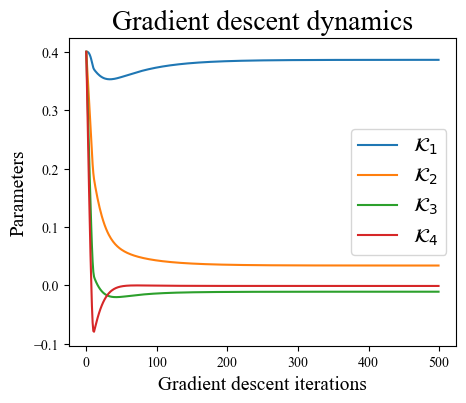

In [51]:
plt.rcParams["figure.figsize"] = (5,4)
plt.figure()
for i in range(4):
    plt.plot(K_blocked_traj_GD_np[:,i], label = "$\\mathcal{K}_"+str(i+1)+" $")
plt.legend(fontsize = 14)
plt.title("Gradient descent dynamics", fontsize = 20)
plt.xlabel("Gradient descent iterations", fontsize=14)
plt.ylabel("Parameters", fontsize=14)
#plt.xscale("log")
plt.show()

#### Many block sizes and RG flow

The only step left is to loop over many block sizes and see how the inferred parameters change with the block size. 

In [72]:
"""This might take a while"""
K_RG = []
Block_sizes = [2,3,4,5,6,8]
for Block_size in Block_sizes:
    Blocked_Samples = Block_configuration(Samples[batch,:,:], Block_size,rng_blocking)
    K_initial = jnp.array([0., 0.,0.0,0.0])
    K = K_initial.copy()
    K_trajectory = []
    Loss_trajectory = []
    eta = 0.05
    for iterations in tqdm(range(300)):
        loss, grad = Pseudo_Loss_fn_and_grad(K, Blocked_Samples)
        K_trajectory.append(K)
        Loss_trajectory.append(loss)
        K = K - eta*grad
    K_blocked_traj_GD_np = jnp.stack(K_trajectory)
    K_RG.append({'b' : Block_size, 'K_traj': K_blocked_traj_GD_np.copy(), 'K': K_blocked_traj_GD_np[-1,:].copy()})

100%|██████████| 300/300 [00:15<00:00, 19.65it/s]


In [78]:
K0 = [jnp.array([K_simulation[0],K_simulation[1],0,0])]
for k in K_RG:
    K0.append(k['K'])  
Ks = jnp.stack(K0)

[]

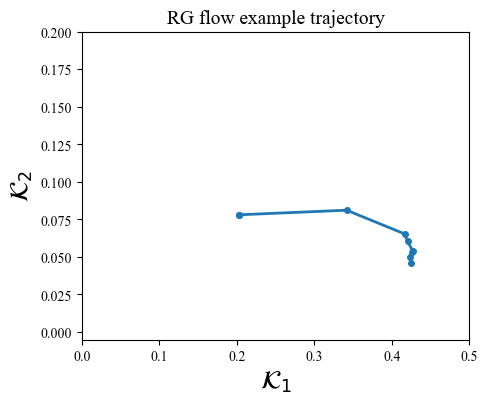

In [90]:
plt.rcParams["figure.figsize"] = (5,4);
K1_traj = list(Ks[:,0].copy())
K2_traj = list(Ks[:,1].copy())
K1_traj.insert(0,K_simulation[0])
K2_traj.insert(0,K_simulation[1])
plt.plot(K1_traj, K2_traj, marker="o", markersize=4, lw = 2)
plt.xlim(0,0.5)
plt.ylim(-0.005,0.2)
plt.xlabel("$\mathcal{K}_1$", fontsize = 18)
plt.ylabel("$\mathcal{K}_2$", fontsize = 18)
plt.title("RG flow example trajectory", fontsize = 14)
plt.plot()

Figures 8 and 9 of the main text are obtained by iterating this procedure for different couplings 

In [88]:
print(Ks[-1])

[0.42438284 0.04588978 0.01217354 0.03285534]
